In [1]:
import gensim
import os
import re
from nltk.tokenize import RegexpTokenizer
import ntpath
import numpy as np
import cPickle as pickle
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from sklearn.model_selection import StratifiedKFold
import random
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, merge,Conv1D,Flatten,GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline

#pretrained word embeddings path
pretrained_emb = "data/GoogleNews-vectors-negative300.bin"
#input_data_folder
input_data_folder = "data/Enron/enron1"
input_pkl = "enron1.pkl"
#different data folder
different_data_folder ="data/Enron/enron2"
#different_pkl
different_pkl = "enron2.pkl"



Using Theano backend.


In [2]:
#Load word2vec model in memory if pkl files are not created
#GoogleNews-vectors-negative300.bin is word2vec model trained over google news dataset
def load_word2vec():
    if(os.path.isfile(input_pkl)==False or os.path.isfile(different_pkl)==False ):
        gensim_model = gensim.models.KeyedVectors.load_word2vec_format(
            pretrained_emb, binary=True)
        return gensim_model
    print("loaded")

In [3]:
#iterate through all filename present in input folder 
#spam label :1, ham label : 0
def read_file_names(input_folder_path):
     path = list()
     for root, directories, filenames in os.walk(input_folder_path):
               for filename in filenames: 
                       filepath = os.path.join(root,filename)  
                       if "spam" or "ham" in filename:
                                path.append(filepath)
     return path
                            
    #removes all non ascii characters
def remove_non_ascii(text):

    return re.sub(r'[^\x00-\x7F]',' ', text) 
 
#read file text from file path and removes all new line characters by whitesopace 
#No need for preprocessing as the data is already preprocessed
def read_file(file_path):
    file = open(file_path, 'r')
    text = file.read().strip()
    file.close()
    text = remove_non_ascii(text)
    return text.lower()
 

In [4]:
#generates average document vectors as average word2vec vectors present in document.
#Checks created dictionary as pkl file for speedup in retesting
#Tried creating doc2vec model but is taking a lot of time
def create_doc_embedding(input_folder, output_pkl, gensim_model):
    X = dict()
    if(os.path.isfile(output_pkl)==False):
        count = 0
        file_list = read_file_names(input_folder)
        tokenizer = RegexpTokenizer(r'\w+')
        for file in file_list:
            count = count+1
            #print(count)
            f =  open(file, 'r')
            st  =f.read()
            name = ntpath.basename(f.name)
            doc_vec = np.zeros(gensim_model.vector_size) # scope for sys arg.
            word_count = 0
            words =tokenizer.tokenize(st)
            for word in words:
                word_vec = np.zeros(gensim_model.vector_size)
                if word in gensim_model.vocab:
                    word_vec = np.array(gensim_model[word])
                    word_count += 1
                    doc_vec = doc_vec + word_vec
            doc_vec = doc_vec / word_count
            X[name] = doc_vec
        pickle.dump(X, open(output_pkl, "wb" ))
    else :
        X = pickle.load(open(output_pkl, "rb"))
    return X
        

In [5]:


#Creates numpy array of document vectors with numpy array of class labels
def create_numpy_array(hmap):
    x = list()
    y = list()
    for val in hmap:
        x.append(np.array(hmap[val]))
        if "spam" in val:
            y.append(1)
        else:
            y.append(0)
        # print(np.array(hmap[val]))
    return np.array(x), np.array(y)


In [6]:
#generate both embeddings
def preprocess_data():
    gensim_model = load_word2vec()
    hash_embedding_input = create_doc_embedding(input_data_folder, input_pkl, gensim_model )
    print("Created embedding 1")
    hash_embedding_diff = create_doc_embedding(different_data_folder, different_pkl,gensim_model )
    print("Created embedding 2")

    return hash_embedding_input, hash_embedding_diff

loaded
Created embedding 1
Created embedding 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 128)               38528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_layer_5 (Dense)        

/usr/local/lib/python2.7/dist-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4138 samples, validate on 1035 samples
Epoch 1/200
4138/4138 [==============================] - 0s - loss: 0.6374 - acc: 0.6605 - val_loss: 0.5603 - val_acc: 0.7101
Epoch 2/200
4138/4138 [==============================] - 0s - loss: 0.5521 - acc: 0.7042 - val_loss: 0.4627 - val_acc: 0.7101
Epoch 3/200
4138/4138 [==============================] - 0s - loss: 0.4615 - acc: 0.7330 - val_loss: 0.3305 - val_acc: 0.8918
Epoch 4/200
4138/4138 [==============================] - 0s - loss: 0.3388 - acc: 0.8434 - val_loss: 0.2167 - val_acc: 0.9208
Epoch 5/200
4138/4138 [==============================] - 0s - loss: 0.2578 - acc: 0.8983 - val_loss: 0.1810 - val_acc: 0.9314
Epoch 6/200
4138/4138 [==============================] - 0s - loss: 0.2244 - acc: 0.9161 - val_loss: 0.1654 - val_acc: 0.9391
Epoch 7/200
4138/4138 [==============================] - 0s - loss: 0.1927 - acc: 0.9287 - val_loss: 0.1436 - val_acc: 0.9478
Epoch 8/200
4138/4138 [==============================] - 0s - loss: 0.

4138/4138 [==============================] - 0s - loss: 0.0267 - acc: 0.9935 - val_loss: 0.1156 - val_acc: 0.9749
Epoch 66/200
4138/4138 [==============================] - 0s - loss: 0.0278 - acc: 0.9930 - val_loss: 0.0891 - val_acc: 0.9816
Epoch 67/200
4138/4138 [==============================] - 0s - loss: 0.0247 - acc: 0.9940 - val_loss: 0.0950 - val_acc: 0.9836
Epoch 68/200
4138/4138 [==============================] - 0s - loss: 0.0257 - acc: 0.9935 - val_loss: 0.0990 - val_acc: 0.9778
Epoch 69/200
4138/4138 [==============================] - 0s - loss: 0.0294 - acc: 0.9928 - val_loss: 0.0926 - val_acc: 0.9787
Epoch 70/200
4138/4138 [==============================] - 0s - loss: 0.0283 - acc: 0.9925 - val_loss: 0.0884 - val_acc: 0.9787
Epoch 71/200
4138/4138 [==============================] - 0s - loss: 0.0248 - acc: 0.9935 - val_loss: 0.1078 - val_acc: 0.9768
Epoch 72/200
4138/4138 [==============================] - 0s - loss: 0.0229 - acc: 0.9937 - val_loss: 0.0991 - val_acc: 0.98

4138/4138 [==============================] - 0s - loss: 0.0211 - acc: 0.9940 - val_loss: 0.1054 - val_acc: 0.9787
Epoch 130/200
4138/4138 [==============================] - 0s - loss: 0.0299 - acc: 0.9906 - val_loss: 0.1146 - val_acc: 0.9758
Epoch 131/200
4138/4138 [==============================] - 0s - loss: 0.0168 - acc: 0.9947 - val_loss: 0.1068 - val_acc: 0.9797
Epoch 132/200
4138/4138 [==============================] - 0s - loss: 0.0129 - acc: 0.9961 - val_loss: 0.1359 - val_acc: 0.9720
Epoch 133/200
4138/4138 [==============================] - 0s - loss: 0.0164 - acc: 0.9959 - val_loss: 0.1026 - val_acc: 0.9778
Epoch 134/200
4138/4138 [==============================] - 0s - loss: 0.0138 - acc: 0.9961 - val_loss: 0.0971 - val_acc: 0.9797
Epoch 135/200
4138/4138 [==============================] - 0s - loss: 0.0131 - acc: 0.9961 - val_loss: 0.1131 - val_acc: 0.9768
Epoch 136/200
4138/4138 [==============================] - 0s - loss: 0.0165 - acc: 0.9957 - val_loss: 0.1531 - val_ac

4138/4138 [==============================] - 0s - loss: 0.0122 - acc: 0.9978 - val_loss: 0.1056 - val_acc: 0.9797
Epoch 194/200
4138/4138 [==============================] - 0s - loss: 0.0107 - acc: 0.9969 - val_loss: 0.1335 - val_acc: 0.9768
Epoch 195/200
4138/4138 [==============================] - 0s - loss: 0.0109 - acc: 0.9966 - val_loss: 0.1241 - val_acc: 0.9807
Epoch 196/200
4138/4138 [==============================] - 0s - loss: 0.0082 - acc: 0.9973 - val_loss: 0.1176 - val_acc: 0.9826
Epoch 197/200
4138/4138 [==============================] - 0s - loss: 0.0094 - acc: 0.9973 - val_loss: 0.1344 - val_acc: 0.9807
Epoch 198/200
4138/4138 [==============================] - 0s - loss: 0.0126 - acc: 0.9961 - val_loss: 0.1301 - val_acc: 0.9797
Epoch 199/200
4138/4138 [==============================] - 0s - loss: 0.0165 - acc: 0.9952 - val_loss: 0.1269 - val_acc: 0.9826
Epoch 200/200
4138/4138 [==============================] - 0s - loss: 0.0235 - acc: 0.9923 - val_loss: 0.1164 - val_ac

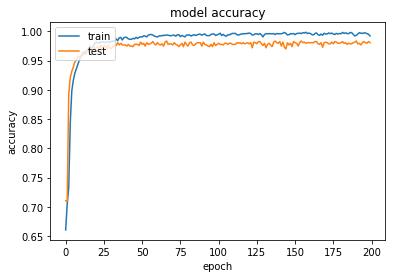

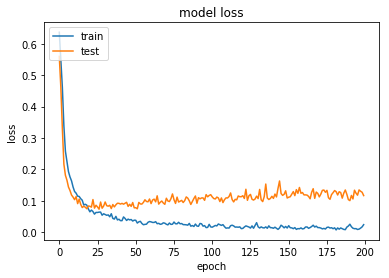

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 128)               38528     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_layer_5 (Dense)        (None, 8)                 264       
__________

4138/4138 [==============================] - 0s - loss: 0.0257 - acc: 0.9932 - val_loss: 0.0991 - val_acc: 0.9797
Epoch 54/200
4138/4138 [==============================] - 0s - loss: 0.0292 - acc: 0.9930 - val_loss: 0.0919 - val_acc: 0.9826
Epoch 55/200
4138/4138 [==============================] - 0s - loss: 0.0321 - acc: 0.9901 - val_loss: 0.1022 - val_acc: 0.9807
Epoch 56/200
4138/4138 [==============================] - 0s - loss: 0.0294 - acc: 0.9903 - val_loss: 0.0918 - val_acc: 0.9836
Epoch 57/200
4138/4138 [==============================] - 0s - loss: 0.0312 - acc: 0.9906 - val_loss: 0.0939 - val_acc: 0.9826
Epoch 58/200
4138/4138 [==============================] - 0s - loss: 0.0304 - acc: 0.9908 - val_loss: 0.0872 - val_acc: 0.9845
Epoch 59/200
4138/4138 [==============================] - 0s - loss: 0.0318 - acc: 0.9908 - val_loss: 0.1062 - val_acc: 0.9797
Epoch 60/200
4138/4138 [==============================] - 0s - loss: 0.0318 - acc: 0.9920 - val_loss: 0.0954 - val_acc: 0.98

4138/4138 [==============================] - 0s - loss: 0.0191 - acc: 0.9947 - val_loss: 0.1025 - val_acc: 0.9836
Epoch 118/200
4138/4138 [==============================] - 0s - loss: 0.0153 - acc: 0.9954 - val_loss: 0.1117 - val_acc: 0.9836
Epoch 119/200
4138/4138 [==============================] - 0s - loss: 0.0164 - acc: 0.9947 - val_loss: 0.1291 - val_acc: 0.9807
Epoch 120/200
4138/4138 [==============================] - 0s - loss: 0.0178 - acc: 0.9961 - val_loss: 0.1140 - val_acc: 0.9836
Epoch 121/200
4138/4138 [==============================] - 0s - loss: 0.0143 - acc: 0.9954 - val_loss: 0.1275 - val_acc: 0.9807
Epoch 122/200
4138/4138 [==============================] - 0s - loss: 0.0139 - acc: 0.9957 - val_loss: 0.1179 - val_acc: 0.9836
Epoch 123/200
4138/4138 [==============================] - 0s - loss: 0.0177 - acc: 0.9952 - val_loss: 0.1218 - val_acc: 0.9807
Epoch 124/200
4138/4138 [==============================] - 0s - loss: 0.0186 - acc: 0.9937 - val_loss: 0.1184 - val_ac

4138/4138 [==============================] - 0s - loss: 0.0128 - acc: 0.9957 - val_loss: 0.1129 - val_acc: 0.9865
Epoch 182/200
4138/4138 [==============================] - 0s - loss: 0.0118 - acc: 0.9966 - val_loss: 0.1147 - val_acc: 0.9865
Epoch 183/200
4138/4138 [==============================] - 0s - loss: 0.0145 - acc: 0.9959 - val_loss: 0.1120 - val_acc: 0.9855
Epoch 184/200
4138/4138 [==============================] - 0s - loss: 0.0199 - acc: 0.9957 - val_loss: 0.1080 - val_acc: 0.9865
Epoch 185/200
4138/4138 [==============================] - 0s - loss: 0.0159 - acc: 0.9937 - val_loss: 0.1220 - val_acc: 0.9816
Epoch 186/200
4138/4138 [==============================] - 0s - loss: 0.0194 - acc: 0.9959 - val_loss: 0.1077 - val_acc: 0.9836
Epoch 187/200
4138/4138 [==============================] - 0s - loss: 0.0154 - acc: 0.9935 - val_loss: 0.1013 - val_acc: 0.9855
Epoch 188/200
4138/4138 [==============================] - 0s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.1027 - val_ac

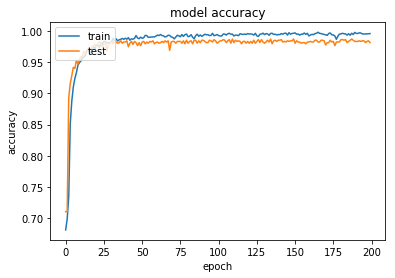

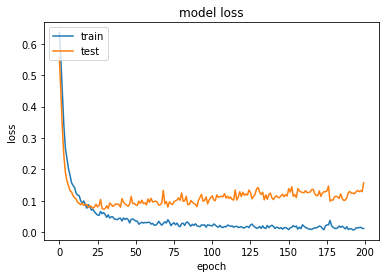

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 128)               38528     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_layer_5 (Dense)        (None, 8)                 264       
__________

4138/4138 [==============================] - 0s - loss: 0.0289 - acc: 0.9918 - val_loss: 0.1106 - val_acc: 0.9768
Epoch 54/200
4138/4138 [==============================] - 0s - loss: 0.0214 - acc: 0.9940 - val_loss: 0.1192 - val_acc: 0.9729
Epoch 55/200
4138/4138 [==============================] - 0s - loss: 0.0277 - acc: 0.9928 - val_loss: 0.1275 - val_acc: 0.9758
Epoch 56/200
4138/4138 [==============================] - 0s - loss: 0.0293 - acc: 0.9906 - val_loss: 0.1200 - val_acc: 0.9739
Epoch 57/200
4138/4138 [==============================] - 0s - loss: 0.0303 - acc: 0.9920 - val_loss: 0.1076 - val_acc: 0.9807
Epoch 58/200
4138/4138 [==============================] - 0s - loss: 0.0292 - acc: 0.9906 - val_loss: 0.1092 - val_acc: 0.9787
Epoch 59/200
4138/4138 [==============================] - 0s - loss: 0.0261 - acc: 0.9915 - val_loss: 0.1131 - val_acc: 0.9758
Epoch 60/200
4138/4138 [==============================] - 0s - loss: 0.0279 - acc: 0.9925 - val_loss: 0.1213 - val_acc: 0.97

4138/4138 [==============================] - 0s - loss: 0.0156 - acc: 0.9964 - val_loss: 0.1225 - val_acc: 0.9787
Epoch 118/200
4138/4138 [==============================] - 0s - loss: 0.0122 - acc: 0.9961 - val_loss: 0.1229 - val_acc: 0.9778
Epoch 119/200
4138/4138 [==============================] - 0s - loss: 0.0161 - acc: 0.9937 - val_loss: 0.1337 - val_acc: 0.9758
Epoch 120/200
4138/4138 [==============================] - 0s - loss: 0.0150 - acc: 0.9947 - val_loss: 0.1334 - val_acc: 0.9758
Epoch 121/200
4138/4138 [==============================] - 0s - loss: 0.0189 - acc: 0.9947 - val_loss: 0.1451 - val_acc: 0.9749
Epoch 122/200
4138/4138 [==============================] - 0s - loss: 0.0144 - acc: 0.9952 - val_loss: 0.1422 - val_acc: 0.9768
Epoch 123/200
4138/4138 [==============================] - 0s - loss: 0.0108 - acc: 0.9969 - val_loss: 0.1624 - val_acc: 0.9797
Epoch 124/200
4138/4138 [==============================] - 0s - loss: 0.0154 - acc: 0.9947 - val_loss: 0.1621 - val_ac

4138/4138 [==============================] - 0s - loss: 0.0095 - acc: 0.9978 - val_loss: 0.1258 - val_acc: 0.9797
Epoch 182/200
4138/4138 [==============================] - 0s - loss: 0.0112 - acc: 0.9964 - val_loss: 0.1390 - val_acc: 0.9807
Epoch 183/200
4138/4138 [==============================] - 0s - loss: 0.0077 - acc: 0.9969 - val_loss: 0.1665 - val_acc: 0.9778
Epoch 184/200
4138/4138 [==============================] - 0s - loss: 0.0101 - acc: 0.9959 - val_loss: 0.1514 - val_acc: 0.9797
Epoch 185/200
4138/4138 [==============================] - 0s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.1523 - val_acc: 0.9749
Epoch 186/200
4138/4138 [==============================] - 0s - loss: 0.0116 - acc: 0.9961 - val_loss: 0.1512 - val_acc: 0.9787
Epoch 187/200
4138/4138 [==============================] - 0s - loss: 0.0162 - acc: 0.9944 - val_loss: 0.1606 - val_acc: 0.9778
Epoch 188/200
4138/4138 [==============================] - 0s - loss: 0.0137 - acc: 0.9952 - val_loss: 0.1469 - val_ac

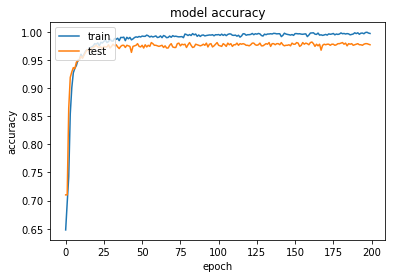

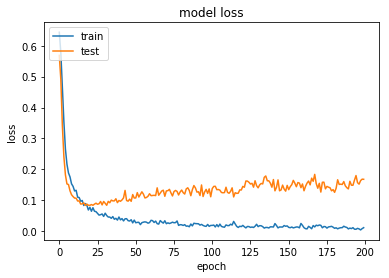

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 128)               38528     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_layer_5 (Dense)        (None, 8)                 264       
__________

4139/4139 [==============================] - 0s - loss: 0.0391 - acc: 0.9908 - val_loss: 0.0838 - val_acc: 0.9758
Epoch 54/200
4139/4139 [==============================] - 0s - loss: 0.0387 - acc: 0.9913 - val_loss: 0.0775 - val_acc: 0.9816
Epoch 55/200
4139/4139 [==============================] - 0s - loss: 0.0336 - acc: 0.9925 - val_loss: 0.0876 - val_acc: 0.9768
Epoch 56/200
4139/4139 [==============================] - 0s - loss: 0.0362 - acc: 0.9920 - val_loss: 0.0843 - val_acc: 0.9787
Epoch 57/200
4139/4139 [==============================] - 0s - loss: 0.0433 - acc: 0.9882 - val_loss: 0.0827 - val_acc: 0.9787
Epoch 58/200
4139/4139 [==============================] - 0s - loss: 0.0415 - acc: 0.9903 - val_loss: 0.0987 - val_acc: 0.9729
Epoch 59/200
4139/4139 [==============================] - 0s - loss: 0.0372 - acc: 0.9923 - val_loss: 0.0874 - val_acc: 0.9787
Epoch 60/200
4139/4139 [==============================] - 0s - loss: 0.0333 - acc: 0.9923 - val_loss: 0.0901 - val_acc: 0.97

4139/4139 [==============================] - 0s - loss: 0.0191 - acc: 0.9947 - val_loss: 0.1093 - val_acc: 0.9807
Epoch 118/200
4139/4139 [==============================] - 0s - loss: 0.0138 - acc: 0.9981 - val_loss: 0.1102 - val_acc: 0.9816
Epoch 119/200
4139/4139 [==============================] - 0s - loss: 0.0199 - acc: 0.9957 - val_loss: 0.1141 - val_acc: 0.9787
Epoch 120/200
4139/4139 [==============================] - 0s - loss: 0.0151 - acc: 0.9971 - val_loss: 0.1281 - val_acc: 0.9778
Epoch 121/200
4139/4139 [==============================] - 0s - loss: 0.0204 - acc: 0.9959 - val_loss: 0.1054 - val_acc: 0.9816
Epoch 122/200
4139/4139 [==============================] - 0s - loss: 0.0225 - acc: 0.9942 - val_loss: 0.1034 - val_acc: 0.9807
Epoch 123/200
4139/4139 [==============================] - 0s - loss: 0.0215 - acc: 0.9954 - val_loss: 0.1081 - val_acc: 0.9778
Epoch 124/200
4139/4139 [==============================] - 0s - loss: 0.0237 - acc: 0.9952 - val_loss: 0.1288 - val_ac

4139/4139 [==============================] - 0s - loss: 0.0160 - acc: 0.9969 - val_loss: 0.1172 - val_acc: 0.9797
Epoch 182/200
4139/4139 [==============================] - 0s - loss: 0.0130 - acc: 0.9964 - val_loss: 0.1140 - val_acc: 0.9836
Epoch 183/200
4139/4139 [==============================] - 0s - loss: 0.0162 - acc: 0.9973 - val_loss: 0.1324 - val_acc: 0.9797
Epoch 184/200
4139/4139 [==============================] - 0s - loss: 0.0194 - acc: 0.9937 - val_loss: 0.1184 - val_acc: 0.9768
Epoch 185/200
4139/4139 [==============================] - 0s - loss: 0.0181 - acc: 0.9954 - val_loss: 0.1165 - val_acc: 0.9807
Epoch 186/200
4139/4139 [==============================] - 0s - loss: 0.0151 - acc: 0.9961 - val_loss: 0.1096 - val_acc: 0.9816
Epoch 187/200
4139/4139 [==============================] - 0s - loss: 0.0097 - acc: 0.9973 - val_loss: 0.1269 - val_acc: 0.9807
Epoch 188/200
4139/4139 [==============================] - 0s - loss: 0.0101 - acc: 0.9973 - val_loss: 0.1333 - val_ac

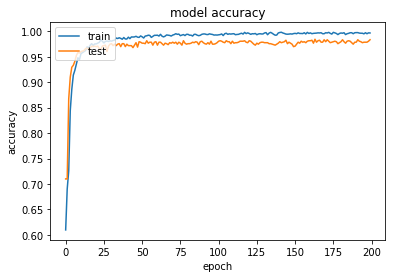

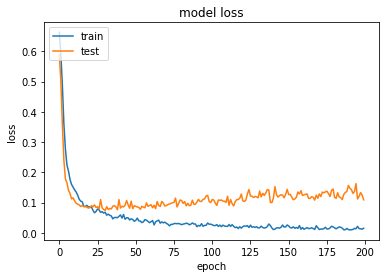

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 128)               38528     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_layer_5 (Dense)        (None, 8)                 264       
__________

4139/4139 [==============================] - 0s - loss: 0.0424 - acc: 0.9838 - val_loss: 0.1044 - val_acc: 0.9749
Epoch 54/200
4139/4139 [==============================] - 0s - loss: 0.0410 - acc: 0.9853 - val_loss: 0.0805 - val_acc: 0.9826
Epoch 55/200
4139/4139 [==============================] - 0s - loss: 0.0316 - acc: 0.9870 - val_loss: 0.0864 - val_acc: 0.9768
Epoch 56/200
4139/4139 [==============================] - 0s - loss: 0.0371 - acc: 0.9884 - val_loss: 0.1019 - val_acc: 0.9778
Epoch 57/200
4139/4139 [==============================] - 0s - loss: 0.0398 - acc: 0.9855 - val_loss: 0.0927 - val_acc: 0.9787
Epoch 58/200
4139/4139 [==============================] - 0s - loss: 0.0237 - acc: 0.9925 - val_loss: 0.0895 - val_acc: 0.9807
Epoch 59/200
4139/4139 [==============================] - 0s - loss: 0.0267 - acc: 0.9920 - val_loss: 0.0980 - val_acc: 0.9787
Epoch 60/200
4139/4139 [==============================] - 0s - loss: 0.0246 - acc: 0.9906 - val_loss: 0.0997 - val_acc: 0.97

4139/4139 [==============================] - 0s - loss: 0.0218 - acc: 0.9901 - val_loss: 0.1618 - val_acc: 0.9700
Epoch 118/200
4139/4139 [==============================] - 0s - loss: 0.0173 - acc: 0.9944 - val_loss: 0.1760 - val_acc: 0.9720
Epoch 119/200
4139/4139 [==============================] - 0s - loss: 0.0172 - acc: 0.9952 - val_loss: 0.1637 - val_acc: 0.9729
Epoch 120/200
4139/4139 [==============================] - 0s - loss: 0.0171 - acc: 0.9947 - val_loss: 0.1756 - val_acc: 0.9720
Epoch 121/200
4139/4139 [==============================] - 0s - loss: 0.0163 - acc: 0.9947 - val_loss: 0.1621 - val_acc: 0.9758
Epoch 122/200
4139/4139 [==============================] - 0s - loss: 0.0207 - acc: 0.9940 - val_loss: 0.1486 - val_acc: 0.9749
Epoch 123/200
4139/4139 [==============================] - 0s - loss: 0.0169 - acc: 0.9930 - val_loss: 0.1406 - val_acc: 0.9768
Epoch 124/200
4139/4139 [==============================] - 0s - loss: 0.0139 - acc: 0.9949 - val_loss: 0.1362 - val_ac

4139/4139 [==============================] - 0s - loss: 0.0117 - acc: 0.9949 - val_loss: 0.1810 - val_acc: 0.9749
Epoch 182/200
4139/4139 [==============================] - 0s - loss: 0.0174 - acc: 0.9944 - val_loss: 0.1667 - val_acc: 0.9758
Epoch 183/200
4139/4139 [==============================] - 0s - loss: 0.0149 - acc: 0.9949 - val_loss: 0.1720 - val_acc: 0.9749
Epoch 184/200
4139/4139 [==============================] - 0s - loss: 0.0199 - acc: 0.9937 - val_loss: 0.1878 - val_acc: 0.9729
Epoch 185/200
4139/4139 [==============================] - 0s - loss: 0.0152 - acc: 0.9954 - val_loss: 0.1771 - val_acc: 0.9749
Epoch 186/200
4139/4139 [==============================] - 0s - loss: 0.0169 - acc: 0.9954 - val_loss: 0.1596 - val_acc: 0.9787
Epoch 187/200
4139/4139 [==============================] - 0s - loss: 0.0111 - acc: 0.9961 - val_loss: 0.1608 - val_acc: 0.9758
Epoch 188/200
4139/4139 [==============================] - 0s - loss: 0.0103 - acc: 0.9969 - val_loss: 0.1841 - val_ac

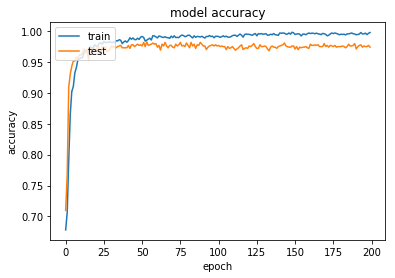

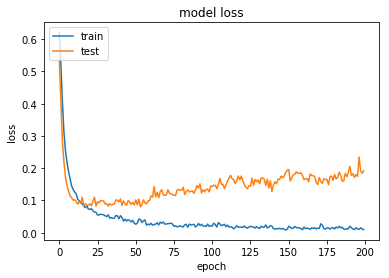

Average F1 Score: 0.964336579102
Confusion matrix:
[[3618   55]
 [  52 1448]]
Average F1 Score: 0.833333333333
Confusion matrix:
[[4157  205]
 [ 281 1215]]


In [7]:

if __name__ == "__main__":
    
    input_dir, different_dir = preprocess_data()
    
    #create trainig and test data in numpy format
    X,Y = create_numpy_array(input_dir)
    
    # number of epochs
    nb_epoch =200
     #dimensionality of embedding
    learning_rate = 0.0001
    seed = 29
    input_dim = 300
    batch_size = 200
    # network definition
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scores = []
    confusion = np.array([[0, 0], [0, 0]])
    for train, test in kfold.split(X, Y):
        model = Sequential()
            #6 layer architecture 
        #model.add(Dense(128, input_shape=(input_dim,), activation='relu', name='dense_layer_1'))
   	    
        #model.add(Dropout(0.5))
       # model.add(Dense(64, activation='relu',name='dense_layer_2'))
        #model.add(Dropout(0.25))
        #model.add(Dense(32, activation='relu',name='dense_layer_3'))
        #model.add(Dropout(0.5))
        #model.add(Dense(16, activation='relu', name='dense_layer_4'))
        #model.add(Dropout(0.25))
        #model.add(Dense(8, activation='relu', name='dense_layer_5'))
        #model.add(Dropout(0.25))
        #model.add(Dense(1, activation='sigmoid', name= 'decision_layer'))
        #5 layer architecture 
        model.add(Dense(128, input_shape=(input_dim,), activation='relu', name='dense_layer_1'))
   	    
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu',name='dense_layer_2'))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='relu',name='dense_layer_3'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='relu', name='dense_layer_5'))
        model.add(Dropout(0.25))
        model.add(Dense(1, activation='sigmoid', name= 'decision_layer'))
        #3 layer architeture
       # model.add(Dense(64, input_shape=(input_dim,), activation='relu', name='dense_layer_1'))
   	    
       # model.add(Dropout(0.5))
       # model.add(Dense(8, activation='relu', name='dense_layer_2'))
       # model.add(Dropout(0.25))
       # model.add(Dense(1, activation='sigmoid', name= 'decision_layer'))
        
        #5 layer architecture
        #model.add(Dense(128, input_shape=(input_dim,), activation='relu', name='dense_layer_1'))
   	    
       # model.add(Dropout(0.5))
        #model.add(Dense(32, activation='relu',name='dense_layer_2'))
        #model.add(Dropout(0.25))
        #model.add(Dense(8, activation='relu', name='dense_layer_3'))
        #model.add(Dropout(0.25))
        #model.add(Dense(1, activation='sigmoid', name= 'decision_layer'))
        model.summary()

# Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
        history = model.fit([X[train]], Y[train],
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=([X[test]], Y[test]))
# evaluate the model
        predictions = model.predict(X[test])
        pred_label =  np.rint(predictions)
        confusion += confusion_matrix(Y[test], pred_label)
        score = f1_score(Y[test], pred_label, pos_label=1)
        scores.append(score)

        print(history.history.keys())
    
# summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
# summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    print('Average F1 Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
#calculate  score for different test data (Robustness results)
    X_diff,Y_diff = create_numpy_array(different_dir)
    predictions = model.predict([X_diff])
    pred_label =  np.rint(predictions)
    confusion = confusion_matrix(Y_diff, pred_label)
    score = f1_score(Y_diff, pred_label, pos_label=1)
    print('Average F1 Score:', score)
    print('Confusion matrix:')
    print(confusion)
    

In [8]:
print('Average F1 Score:', score)

Average F1 Score: 0.833333333333
